In [1]:
# ─── Imports & env ────────────────────────────────────────────────────────────
import os, time, numpy as np, torch, cv2, matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO
from rfdetr import RFDETRBase

# enable CPU fallback for one unsupported MPS op
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"✅ Using device: {device}")

# ─── Models (instantiate once) ───────────────────────────────────────────────
home          = os.path.expanduser("~")
yolo_weights  = f"{home}/models/jakes-loped/jakes-finder-mk1/1/weights.pt"
jake_weights  = f"{home}/downloads/weightsjake.pt"

yolo_model = YOLO(yolo_weights)
jake_model = RFDETRBase(pretrain_weights=jake_weights, num_classes=3)

# optional warm-up
sample = f"{home}/SubwaySurfers/train_screenshots/frame_0000.jpg"
_ = yolo_model.predict(source=sample, task="segment", conf=0.25)[0]
_ = jake_model.predict(Image.open(sample), threshold=0.4, device=device)

class Footing:
    def overlay_mask(self, rgb_img: np.ndarray, mask_bool: np.ndarray, alpha=0.4):
        """
        rgb_img  : H×W×3  uint8  (full-res frame)
        mask_bool: h×w     bool / 0-1 / 0-255
        """
        H, W = rgb_img.shape[:2]
    
        # ensure mask is uint8 0/255 and same size as rgb
        mask_uint8 = (mask_bool.astype(np.uint8) * 255)
        if mask_uint8.shape[:2] != (H, W):
            mask_uint8 = cv2.resize(
                mask_uint8, (W, H), interpolation=cv2.INTER_NEAREST
            )
    
        red_layer = np.zeros_like(rgb_img, dtype=np.uint8)
        red_layer[:, :, 0] = mask_uint8            # put mask into R channel
        blended = cv2.addWeighted(red_layer, alpha, rgb_img, 1 - alpha, 0)
        return blended
    
    # ─── main per-frame analysis ────────────────────────────────────────────────
    def analyse_frame(self, j, i):
        frame_path = os.path.expanduser(
            f"~/SubwaySurfers/train_screenshots/frame_00{j}{i}.jpg"
        )
        pil_img = Image.open(frame_path)
        rgb     = np.array(pil_img)                      # full-res frame (H_img×W_img)
    
        # 1) RFDETR  → Jake bbox in full-image coords
        jdet = jake_model.predict(pil_img, threshold=0.5, device=device)[0]
        x1, y1, x2, y2 = jdet.xyxy[0].astype(int)
    
        # 2) YOLO seg → masks in network resolution (H_msk×W_msk)
        yres      = yolo_model.predict(source=pil_img, task="segment", conf=0.30)[0]
        masks     = yres.masks.data.cpu().numpy()          # (N,H_msk,W_msk) bool
        class_ids = yres.boxes.cls.cpu().numpy().astype(int)
    
        H_img, W_img = rgb.shape[:2]
        H_msk, W_msk = masks.shape[1:]
        sx, sy = W_msk / W_img, H_msk / H_img              # scale factors
    
        # scale Jake bbox into mask coordinates
        mx1, mx2 = int(x1 * sx), int(x2 * sx)
        my1, my2 = int(y1 * sy), int(y2 * sy)
    
        # 3) pick mask with largest pixel intersection in mask space
        best_idx, best_cid, best_area = None, None, 0
        for idx, cid in enumerate(class_ids):
            area = masks[idx, my1:my2, mx1:mx2].sum()
            if area > best_area:
                best_idx, best_cid, best_area = idx, int(cid), int(area)
    
        if best_idx is None:
            print("⚠️  No overlap")
        else:
            cname = yolo_model.names[best_cid]
            print(f"Overlap → mask {best_idx}, class {best_cid} ('{cname}'), "
                  f"pixels: {best_area}")
    
        # 4) visualise 
        vis = rgb.copy()
        cv2.rectangle(vis, (x1, y1), (x2, y2), color=(0,255,0), thickness=2)
        if best_idx is not None:
            vis = self.overlay_mask(vis, masks[best_idx], alpha=0.4)
    
        plt.figure(figsize=(10,6))
        plt.imshow(vis); plt.axis("off"); plt.show()


run = Footing()
for i in range(5):
    run.analyse_frame(1, i)



✅ Using device: mps
Loading pretrain weights

image 1/1 /Users/marcus/SubwaySurfers/train_screenshots/frame_0000.jpg: 864x1504 2 ORANGETRAINs, 1 Rails, 4 YELLOWTRAINs, 345.2ms
Speed: 9.9ms preprocess, 345.2ms inference, 29.8ms postprocess per image at shape (1, 3, 864, 1504)


Model is not optimized for inference. Latency may be higher than expected. You can optimize the model for inference by calling model.optimize_for_inference().


NotImplementedError: The operator 'aten::_upsample_bicubic2d_aa.out' is not currently implemented for the MPS device. If you want this op to be considered for addition please comment on https://github.com/pytorch/pytorch/issues/141287 and mention use-case, that resulted in missing op as well as commit hash e2d141dbde55c2a4370fac5165b0561b6af4798b. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

✅ Using device: mps
Loading pretrain weights

image 1/1 /Users/marcus/SubwaySurfers/train_screenshots/frame_0000.jpg: 864x1504 2 ORANGETRAINs, 1 Rails, 4 YELLOWTRAINs, 266.3ms
Speed: 10.2ms preprocess, 266.3ms inference, 14.8ms postprocess per image at shape (1, 3, 864, 1504)


Model is not optimized for inference. Latency may be higher than expected. You can optimize the model for inference by calling model.optimize_for_inference().



0: 864x1504 3 GREYTRAINs, 1 RAMP, 1 Rails, 291.2ms
Speed: 12.6ms preprocess, 291.2ms inference, 11.0ms postprocess per image at shape (1, 3, 864, 1504)
Overlap → mask 3, class 9 ('Rails'), pixels=26827


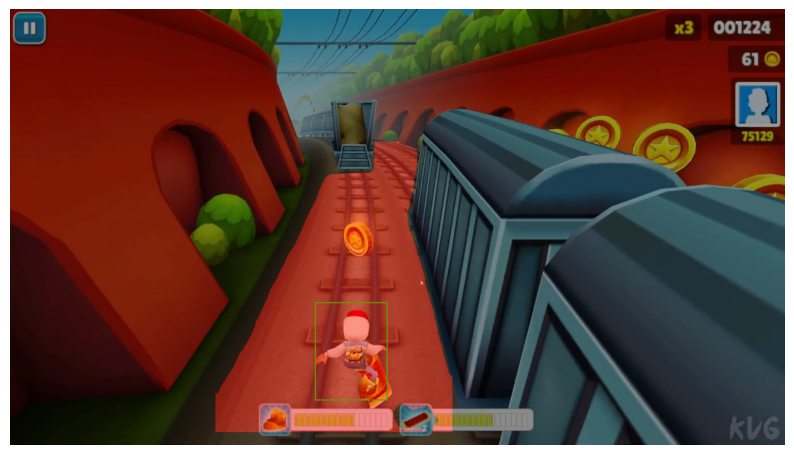


0: 864x1504 2 GREYTRAINs, 1 RAMP, 3 Railss, 1 YELLOWTRAIN, 249.4ms
Speed: 7.7ms preprocess, 249.4ms inference, 10.9ms postprocess per image at shape (1, 3, 864, 1504)
Overlap → mask 0, class 8 ('RAMP'), pixels=39480


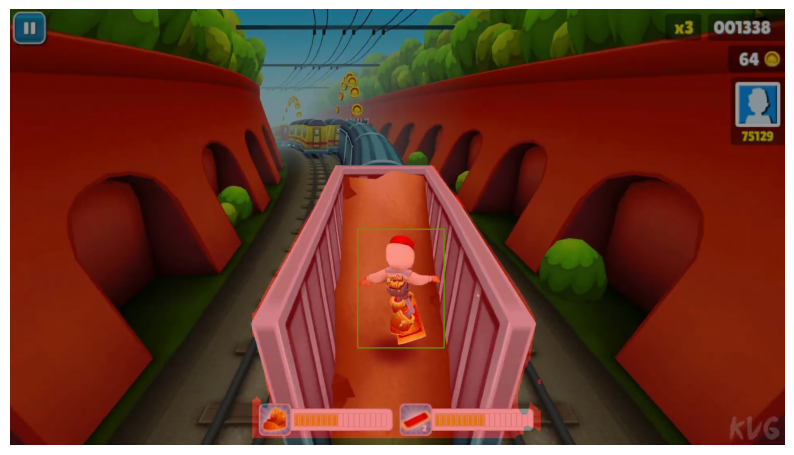


0: 864x1504 2 ORANGETRAINs, 1 Rails, 4 YELLOWTRAINs, 244.0ms
Speed: 6.8ms preprocess, 244.0ms inference, 10.4ms postprocess per image at shape (1, 3, 864, 1504)
Overlap → mask 5, class 11 ('YELLOWTRAIN'), pixels=9764


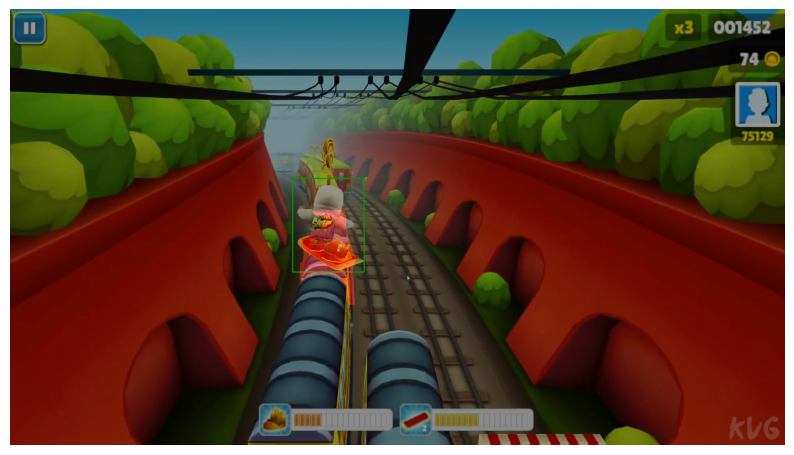


0: 864x1504 1 LOWBARRIER1, 4 ORANGETRAINs, 1 RAMP, 3 Railss, 1 YELLOWTRAIN, 225.8ms
Speed: 6.4ms preprocess, 225.8ms inference, 19.6ms postprocess per image at shape (1, 3, 864, 1504)
Overlap → mask 4, class 6 ('ORANGETRAIN'), pixels=26364


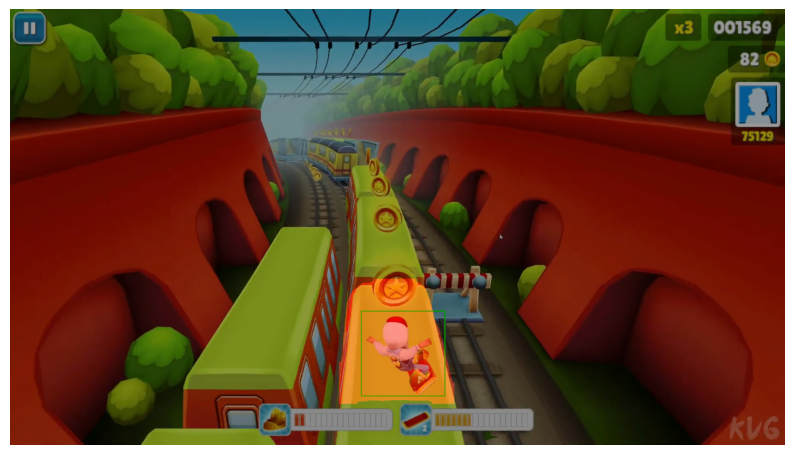


0: 864x1504 1 GREYTRAIN, 2 ORANGETRAINs, 2 RAMPs, 1 Rails, 2 YELLOWTRAINs, 261.0ms
Speed: 8.3ms preprocess, 261.0ms inference, 17.0ms postprocess per image at shape (1, 3, 864, 1504)
Overlap → mask 0, class 8 ('RAMP'), pixels=18354


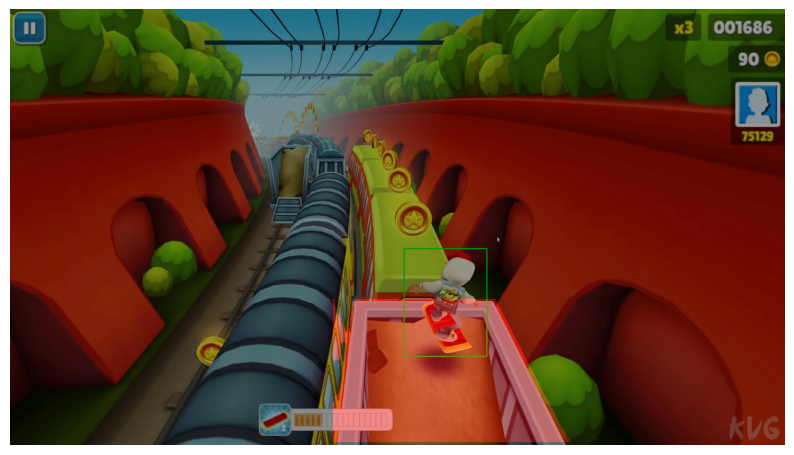

In [3]:
#!/usr/bin/env python3

import os
# ── Enable CPU fallback before importing torch ────────────────────────────────
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import time
import numpy as np
import torch
import torch.nn.functional as F

# ── Monkey-patch interpolate to disable antialiasing (avoids unsupported MPS op) ──
_original_interpolate = F.interpolate
def _interpolate_no_antialias(input, *args, **kwargs):
    kwargs['antialias'] = False
    return _original_interpolate(input, *args, **kwargs)
F.interpolate = _interpolate_no_antialias

import cv2
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO
from rfdetr import RFDETRBase

# ── Device ─────────────────────────────────────────────────────────────────────
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"✅ Using device: {device}")

# ── Model paths & instantiation ─────────────────────────────────────────────────
home         = os.path.expanduser("~")
yolo_weights = f"{home}/models/jakes-loped/jakes-finder-mk1/1/weights.pt"
jake_weights = f"{home}/downloads/weightsjake.pt"

yolo_model = YOLO(yolo_weights)
jake_model = RFDETRBase(pretrain_weights=jake_weights, num_classes=3)

# ── Warm-up (triggers the fallback once if needed) ──────────────────────────────
sample = f"{home}/SubwaySurfers/train_screenshots/frame_0000.jpg"
_ = yolo_model.predict(source=sample, task="segment", conf=0.25)[0]
try:
    _ = jake_model.predict(Image.open(sample).convert("RGB"), threshold=0.4, device=device)
except NotImplementedError:
    _ = jake_model.predict(Image.open(sample).convert("RGB"), threshold=0.4, device="cpu")

class Footing:
    def overlay_mask(self, rgb_img: np.ndarray, mask_bool: np.ndarray, alpha=0.4):
        H, W = rgb_img.shape[:2]
        mask_uint8 = (mask_bool.astype(np.uint8) * 255)
        if mask_uint8.shape[:2] != (H, W):
            mask_uint8 = cv2.resize(mask_uint8, (W, H), interpolation=cv2.INTER_NEAREST)
        red_layer = np.zeros_like(rgb_img, dtype=np.uint8)
        red_layer[:, :, 0] = mask_uint8
        return cv2.addWeighted(red_layer, alpha, rgb_img, 1 - alpha, 0)

    def analyse_frame(self, j, i):
        frame_path = os.path.expanduser(f"~/SubwaySurfers/train_screenshots/frame_00{j}{i}.jpg")
        pil_img = Image.open(frame_path).convert("RGB")
        rgb     = np.array(pil_img)

        # 1) RF-DETR bounding box
        try:
            dets = jake_model.predict(pil_img, threshold=0.5, device=device)[0]
        except NotImplementedError:
            dets = jake_model.predict(pil_img, threshold=0.5, device="cpu")[0]
        x1, y1, x2, y2 = dets.xyxy[0].astype(int)

        # 2) YOLO segmentation masks
        yres      = yolo_model.predict(source=pil_img, task="segment", conf=0.30)[0]
        masks     = yres.masks.data.cpu().numpy()
        class_ids = yres.boxes.cls.cpu().numpy().astype(int)

        H_img, W_img = rgb.shape[:2]
        H_m, W_m     = masks.shape[1:]
        sx, sy       = W_m / W_img, H_m / H_img
        mx1, mx2 = int(x1 * sx), int(x2 * sx)
        my1, my2 = int(y1 * sy), int(y2 * sy)

        # 3) pick mask with largest overlap
        best_idx, best_cid, best_area = None, None, 0
        for idx, cid in enumerate(class_ids):
            area = masks[idx, my1:my2, mx1:mx2].sum()
            if area > best_area:
                best_idx, best_cid, best_area = idx, int(cid), int(area)

        if best_idx is None:
            print("⚠️ No overlap found")
        else:
            cname = yolo_model.names[best_cid]
            print(f"Overlap → mask {best_idx}, class {best_cid} ('{cname}'), pixels={best_area}")

        # 4) visualize
        vis = rgb.copy()
        cv2.rectangle(vis, (x1, y1), (x2, y2), (0,255,0), 2)
        if best_idx is not None:
            vis = self.overlay_mask(vis, masks[best_idx], alpha=0.4)

        plt.figure(figsize=(10,6))
        plt.imshow(vis)
        plt.axis("off")
        plt.show()

if __name__ == "__main__":
    run = Footing()
    for i in range(5):
        run.analyse_frame(1, i)


In [4]:
import os
from rfdetr import RFDETRBase
from PIL import Image
import supervision as sv
import time
import torch

def cycle2(j,i):

    device = "mps" if torch.backends.mps.is_available() else "cpu"
    print(f"✅ Using device: {device}")

    start = time.time()
    # point 'weightsjake.pt' at your locally-saved checkpoint
    weights_path = os.path.expanduser("~/downloads/weightsjake.pt")
    
    # instantiate with your custom weights
    model = RFDETRBase(
      pretrain_weights=weights_path,
      num_classes=3,            # ← match your checkpoint
    )
    
    # now do your usual inference…
    image = Image.open(os.path.expanduser(f"~/SubwaySurfers/train_screenshots/frame_00{j}{i}.jpg"))
    detections = model.predict(image, threshold=0.5)
    
    # visualize
    annot = image.copy()
    annot = sv.BoxAnnotator().annotate(annot, detections)
    annot = sv.LabelAnnotator().annotate(annot, detections,
                                         [f"{cid} {conf:.2f}" for cid, conf in zip(detections.class_id, detections.confidence)])
    sv.plot_image(annot)
    end = time.time()
    
    print(f"Inference time: {(end - start) * 1000:.2f} ms")
    print(detections)




✅ Using device: mps
Loading pretrain weights


Model is not optimized for inference. Latency may be higher than expected. You can optimize the model for inference by calling model.optimize_for_inference().


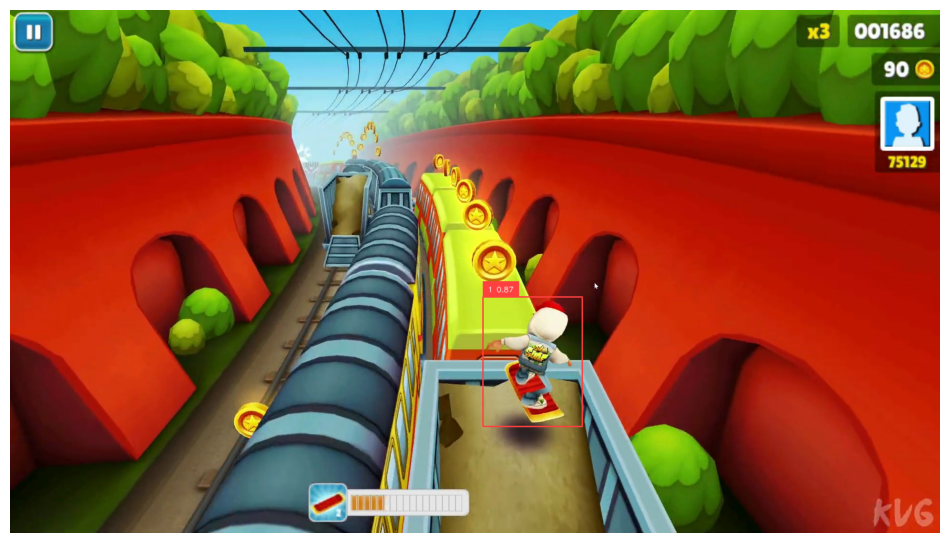

Inference time: 1722.92 ms
Detections(xyxy=array([[     976.73,      593.76,      1181.1,      860.68]], dtype=float32), mask=None, confidence=array([    0.86674], dtype=float32), class_id=array([1]), tracker_id=None, data={}, metadata={})


In [5]:
cycle2(1,4)